# Main Quest04. 폐렴아 기다려라!

**폐렴(Pneumonia)을 진단하는 딥러닝 모델 만들기**

* Set-up
* 데이터 가져오기
* 데이터 시각화
* CNN 모델링
* 데이터 imbalance 처리
* 모델 훈련
* 결과 확인
* ResNet-18 모델 이용하여 분류하기

In [2]:
# 주요 라이브러리 버전 확인
import tensorflow

print(tensorflow.__version__)

2.6.0


### **1. Set-up**

패키지(라이브러리)들을 import

In [3]:
import os, re
import random, math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import warnings 
warnings.filterwarnings(action='ignore')

In [4]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # 메모리 사용 제한을 위한 설정
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    # 특정 GPU만 사용하도록 설정
    tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
  except RuntimeError as e:
    # 프로그램 시작 후에는 GPU 설정을 변경할 수 없으므로
    # 런타임 오류 발생 시 예외 처리가 필요함
    print(e)

Num GPUs Available:  1


필요한 변수들을 생성

In [5]:
# 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE
# X-RAY 이미지 사이즈 변수
IMAGE_SIZE = [180, 180]

# 데이터 경로 변수
ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel')
TRAIN_PATH = ROOT_PATH + '/chest_xray/data/train/*/*' # *은 모든 디렉토리와 파일을 의미합니다.
VAL_PATH = ROOT_PATH + '/chest_xray/data/val/*/*'
TEST_PATH = ROOT_PATH + '/chest_xray/data/test/*/*'

# 프로젝트를 진행할 때 아래 두 변수를 변경해보세요
BATCH_SIZE = 16
EPOCHS = 10

print(ROOT_PATH)

/aiffel/aiffel


### 2. 데이터 가져오기
데이터를 열어보면 데이터는 train, val(validation), test 로 나누어져 있다.

In [6]:
# 데이터 개수 체크
train_filenames = tf.io.gfile.glob(TRAIN_PATH)
test_filenames = tf.io.gfile.glob(TEST_PATH)
val_filenames = tf.io.gfile.glob(VAL_PATH)

print(len(train_filenames))
print(len(test_filenames))
print(len(val_filenames))

5216
624
16


* train 데이터 - 5216개
* test 데이터 - 624개
* val 데이터 - 16개

개수 비는 89%, 10.7%, 0.3% 입니다. val 개수가 너무 없기 때문에 train에서 val에 쓰일 데이터를 더 가져와보겠다.

**rain과 val에 있는 데이터를 모은 다음에 train : val를 80:20으로 분할**

In [7]:
# train 데이터와 validation 데이터를 모두 filenames에 담습니다
filenames = tf.io.gfile.glob(TRAIN_PATH)
filenames.extend(tf.io.gfile.glob(VAL_PATH))

# 모아진 filenames를 8:2로 나눕니다
train_size = math.floor(len(filenames)*0.8)
random.seed(8)
random.shuffle(filenames)
train_filenames = filenames[:train_size]
val_filenames = filenames[train_size:]

print(len(train_filenames))
print(len(val_filenames))

4185
1047


이제 train은 4185개, test는 624개, val은 1047개가 되었다. test_size를 수정하면 개수는 달라질 수 있다.

train 데이터 안에 정상 이미지 수와 폐렴 이미지 수를 한번 확인해보자

정상 이미지와 폐렴 이미지를 구분해야 하는데 다행히도 파일 경로에 힌트가 있다.

In [8]:
print(f'Normal image path\n{filenames[0]}')
print(f'Pneumonia image path\n{filenames[2000]}')

Normal image path
/aiffel/aiffel/chest_xray/data/train/PNEUMONIA/person774_virus_1403.jpeg
Pneumonia image path
/aiffel/aiffel/chest_xray/data/train/PNEUMONIA/person1345_bacteria_3422.jpeg


이제 파일 경로에 NORMAL이 있는지 확인하면 정상 이미지를 셀 수 있다. 또한, 파일 경로에 PNEUMONIA이 있는지 확인하면 폐렴 이미지도 셀 수 있다.

In [9]:
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print(f"Normal images count in training set: {COUNT_NORMAL}")


COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print(f"Pneumonia images count in training set: {COUNT_PNEUMONIA}")

Normal images count in training set: 1081
Pneumonia images count in training set: 3104


* 결과를 보면 정상보다 폐렴 이미지 수가 3배 더 많이 있다. 
* 사용할 CNN 모델의 경우 데이터가 클래스별 balance가 좋을수록 training을 잘 한다. 
* 데이터가 클래스 불균형(imbalance)한 것은 차후에 조정할 예정
* test와 val 데이터셋은 평가하기 위해서 사용되기 때문에 학습과 관련이 없으므로 imbalance한 데이터 셋이어도 문제없다.

tf.data 인스턴스를 만들어 보자. tf.data는 tensorflow에서 학습시킬 때, mini-batch로 작업할 수 있도록 해준다.

In [10]:
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

In [11]:
# Train 데이터셋, validation 데이터셋 개수 확인
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print(f"Training images count: {TRAIN_IMG_COUNT}")

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print(f"Validating images count: {VAL_IMG_COUNT}")

Training images count: 4185
Validating images count: 1047


현재 이미지에는 라벨 데이터가 따로 없다.

파일 경로에 'NORMAL'이나 'PNEUMONIA'가 포함되어 있기 때문에 이를 이용해서 라벨 데이터를 만들어 주는 함수를 만들어 보겠다.

In [12]:
# 파일 경로의 끝에서 두번째 부분을 확인하면 양성과 음성을 구분할 수 있다
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "PNEUMONIA"   # 폐렴이면 양성(True), 노말이면 음성(False)

* 이미지 데이터는 현실적으로 사이즈가 제각각일 가능성이 높다.
* 이미지의 사이즈를 통일 시키고 GPU 메모리를 더욱 효율적으로 사용하기 위해 이미지 사이즈를 줄여본다.
* decode_img 함수와 process_path 함수를 만든다.

process_path 함수에서 decode_img 함수를 이용해서 이미지의 데이터 타입을 float으로 바꾸고 사이즈를 변경한다. get_label을 이용해서 라벨 값을 가져온다.

In [13]:
# 이미지를 알맞은 형식으로 바꾼다.
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3) # 이미지를 uint8 tensor로 수정
    img = tf.image.convert_image_dtype(img, tf.float32) # float32 타입으로 수정
    img = tf.image.resize(img, IMAGE_SIZE) # 이미지 사이즈를 IMAGE_SIZE로 수정
    return img

# 이미지 파일의 경로를 입력하면 이미지와 라벨을 읽어온다.
def process_path(file_path):
    label = get_label(file_path) # 라벨 검출
    img = tf.io.read_file(file_path) # 이미지 읽기
    img = decode_img(img) # 이미지를 알맞은 형식으로 수정
    return img, label

train 데이터 셋과 validation 데이터 셋을 만든다. num_parallel_calls 파라미터에 위에서 할당한 AUTOTUNE변수를 이용하면 더욱 빠르게 데이터를 처리해 즐 수 있다.

In [14]:
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [15]:
# 이미지가 잘 리사이즈 되었는지, 그리고 라벨이 잘 들어가 있는지 확인
for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  True


사이즈가 잘 변환되어 있고 라벨도 잘 들어가 있는 것을 볼 수있다. 참고로, 코드에서 train_ds.take(1)은 하나의 데이터만 가져온다는 의미이다.

In [16]:
# test 데이터셋을 만들고, 데이터 개수도 확인
test_list_ds = tf.data.Dataset.list_files(TEST_PATH)
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print(TEST_IMAGE_COUNT)

624


### Data augmentation(데이터 증강)
의료 영상 이미지 특성 상 데이터는 언제나 충분하지 않다. 이를 극복하는 방법으로 Data augmentation 기법을 활용해보자.

일반적인 이미지 처리에서 사용하는 augmentation들이 항상 도움이 된다고 말할 수 없다. 특히 X-RAY 같은 의료 영상의 특성상, 육안으로도 구분하기 어려운 미묘한 차이에 더해진 노이즈 등 부수효과가 오히려 방해를 줄 수도 있기 때문이다.
그래서 augmentation 도입은 신중해야 한다.

In [17]:
def augment(image,label):
    image = tf.image.random_flip_left_right(image)  # 랜덤하게 좌우를 반전합니다.
#     image = tf.cast(image, tf.float32) / 255.0    # 이미지를 0-1 사이 값으로 스케일링
    return image,label

def prepare_for_training(ds, shuffle_buffer_size=1000):
    # augment 적용 부분이 배치처리 함수에 추가되었습니다.
    ds = ds.map(
            augment,       # augment 함수 적용
            num_parallel_calls=2
        )
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

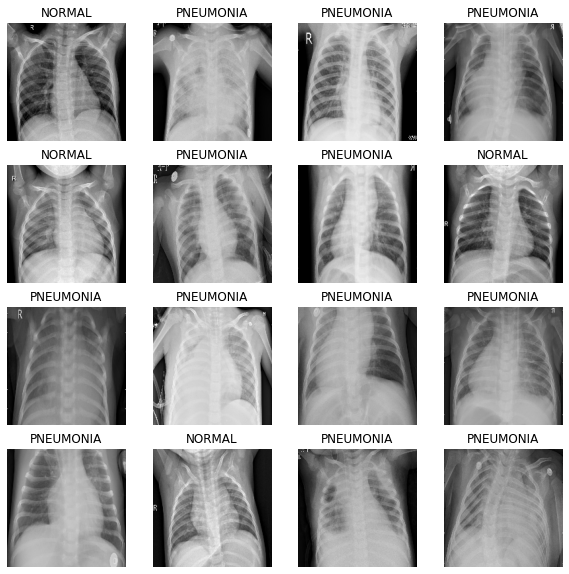

In [18]:
# Data Augmentation이 제대로 되었는지 확인(데이터 시각화)
# 이미지 배치를 입력하면 여러장의 이미지를 보여줍니다.
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(BATCH_SIZE):
        ax = plt.subplot(4,math.ceil(BATCH_SIZE/4),n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")


image_batch, label_batch = next(iter(train_ds))
show_batch(image_batch.numpy(), label_batch.numpy())

### CNN 모델링
이미지 처리에 특화된 딥러닝 모델인 CNN을 통해 모델링을 하고 결과를 만들어 보겠다.

먼저, Convolution block을 만든다. conv_block()의 구성은 Convolution을 두 번 진행하고 Batch Normalization을 통해서 Gradient vanishing, Gradient Exploding을 해결한다. 그리고 Max Pooling을 한다.

In [19]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])
    
    return block

In [20]:
# Dense Block 함수
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

만들 CNN 모델은 약간의 수정을 거쳐 만들어진 모델이다. 전형적인 CNN 모델과는 약간 다른 모델이다.

방금 만들어진 모델에는 Batch Normalization과 Dropout이라는 두 가지 regularization 기법이 동시에 사용되고 있다.
일반적으로 이런 방법은 잘 사용되지 않거나, 금기시되기도 한다. 대표적으로 아래와 같은 논문의 사례를 들 수 있다.

* Understanding the Disharmony between Dropout and Batch Normalization by Variance Shift

위 논문에서는 variance shift를 억제하는 Batch Normalization과 이를 유발하는 Dropout을 동시에 사용하는 것이 어울리지 않는다고 밝히고 있다.

그러나, 실용적으로는 두 방법을 같이 쓰는 것이 낫다고 보는 견해도 없는 것은 아니다. 예외적으로 동시에 사용하는 것이 성능 향상에 도움을 주는 경우가 실제로 있다. 아래 논문과 같이 두 방법을 같이 쓰는 것을 옹호하는 경우도 있다.

* Rethinking the Usage of Batch Normalization and Dropout in the Training of Deep Neural Networks

이번 실습에서는 두 가지를 함께 사용하는 이 모델이 성능 향상에 도움이 될지 여부도 흥미롭게 살펴볼만 한 부분이다.

In [21]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

### 5. 데이터 imbalance 처리
Normal'과 폐렴에서 'Pneumonia' 중에 'Pneumonia' 데이터가 많이 있다. 한 라벨이 너무 많은 경우를 imbalance 하다고 하는데, 데이터를 학습할 때 imbalance한 데이터의 경우 학습 효과가 좋지 않을 수 있다.
Weight balancing 은 training set의 각 데이터에서 loss를 계산할 때 특정 클래스의 데이터에 더 큰 loss 값을 갖도록 가중치를 부여하는 방법이다. Keras는 model.fit()을 호출할 때 파라미터로 넘기는 class_weight 에 이러한 클래스별 가중치를 세팅할 수 있도록 지원하고 있습니다. 상세한 내용은 아래 링크를 참고하자.

https://3months.tistory.com/414

아래 코드에서 weight_for_0은 'Normal' 이미지에 사용할 weight를, weight_for_1은 'Pneumonia' 이미지에 사용할 weight를 세팅힌다. 이 weight들은 'Normal'과 'Pneumonia' 전체 데이터 건수에 반비례하도록 설정

In [22]:
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

Weight for NORMAL: 1.94
Weight for PNEUMONIA: 0.67


### 6. 모델 훈련
* 이미지 훈련은 GPU를 사용할 것이기 때문에 먼저 GPU를 선택한다. 
* 모델은 위에서 만들었던 모델 함수인 build_model()을 model에 선언한다.
* 이미지의 라벨이 두 개밖에 없기 때문에 "binary_cross entropy" loss를 사용한다.
* optimizer로 'adam'을 사용한다.
* 성과에 대해서 측정하기 위한 metrics으로 'accuracy', 'precision', 'recall'을 사용한다.

In [29]:
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001) # 학습률 0.0001로 설정
    model.compile(
        optimizer=optimizer,
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [30]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/10
261/261 [==============================] - 64s 208ms/step - loss: 0.5682 - accuracy: 0.6952 - precision: 0.9203 - recall: 0.6448 - val_loss: 0.7650 - val_accuracy: 0.2558 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/10
261/261 [==============================] - 54s 206ms/step - loss: 0.3928 - accuracy: 0.8068 - precision: 0.9655 - recall: 0.7670 - val_loss: 0.5731 - val_accuracy: 0.7433 - val_precision: 0.7433 - val_recall: 1.0000
Epoch 3/10
261/261 [==============================] - 54s 206ms/step - loss: 0.3249 - accuracy: 0.8446 - precision: 0.9726 - recall: 0.8134 - val_loss: 0.3278 - val_accuracy: 0.8212 - val_precision: 0.8065 - val_recall: 1.0000
Epoch 4/10
261/261 [==============================] - 55s 211ms/step - loss: 0.2912 - accuracy: 0.8664 - precision: 0.9731 - recall: 0.8429 - val_loss: 1.6486 - val_accuracy: 0.4615 - val_precision: 1.0000 - val_recall: 0.2755
Epoch 5/10
261/261 [==============================] - 56s 214ms/step - loss: 0.2468 

### 결과 확인
이제 결과를 확인해보다. 그래프로 Epochs 마다 모델의 precision, recall, accuracy, loss가 어떻게 변하는지 보여준다.

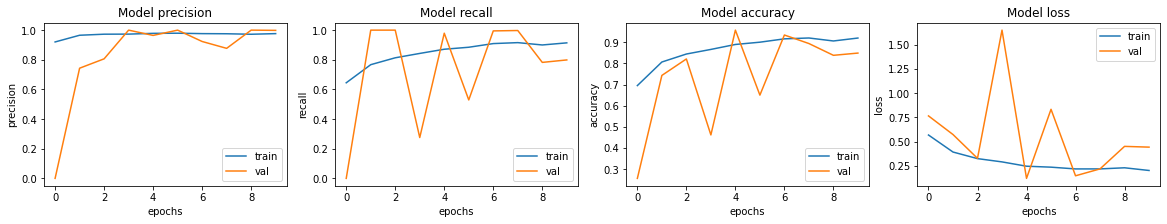

In [31]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [32]:
# 테스트 데이터로 모델 평가
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 5s 135ms/step - loss: 0.3725 - accuracy: 0.8526 - precision: 0.8744 - recall: 0.8923
Loss: 0.3725394010543823,
Accuracy: 0.8525640964508057,
Precision: 0.8743718862533569,
Recall: 0.892307698726654


### ResNet-18 구현

ResNet은 Residual block을 먼저 구성해야 합니다. ResNet에서의 weight layer는

* 3x3 CNN
* BatchNormalization
* 활성화 함수 ReLU
로 구성되어 있습니다.

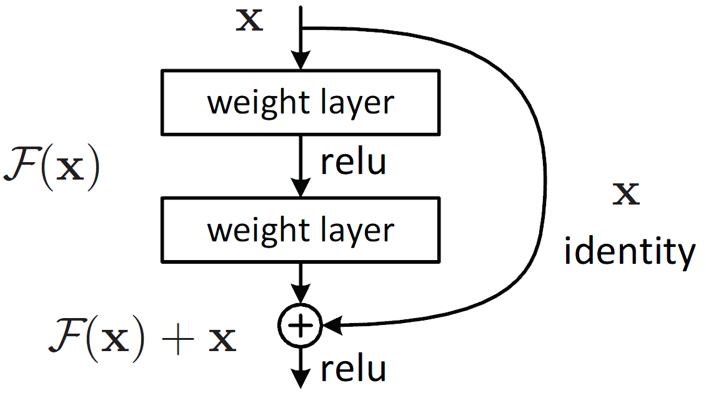

위에 있는 그림대로 Residual block을 구성했다면 이제는 아래 그림을 보고 ResNet을 구현해주세요 (참고사항 : 해당 table은 ImageNet Challenge를 가정했기 때문에 filter개수는 튜닝하면서 바꿔주세요!)

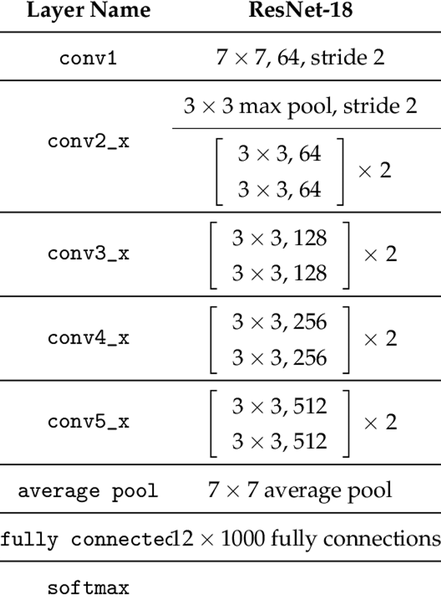

In [34]:
# 이미지 데이터 체크
for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (16, 180, 180, 3)
Label:  [ True  True  True  True  True  True  True  True  True False  True False
  True  True  True  True]


In [42]:
# import tensorflow as tf
# from tensorflow.keras.layers import Input, Conv2D, BatchNormalization
# from tensorflow.keras.layers import ReLU, GlobalAveragePooling2D, MaxPooling2D, Dense, Add, AveragePooling2D

# def conv_block(inputs, filters, kernel_size, strides):
#     x = Conv2D(filters, kernel_size=kernel_size, strides=strides, padding='same')(inputs)
#     x = BatchNormalization()(x)
#     x = ReLU()(x)
#     return x

# def identity_block(inputs, kernel, filters, strides=1, activation='relu'):
#     x = conv_block(inputs, filters, kernel_size=3, strides=1)
#     x = Conv2D(filters, kernel_size=3, strides=1, padding='same')(x)
#     x = BatchNormalization()(x)
#     x = Add()([x, inputs])
#     x = ReLU()(x)
#     return x

# def resnet_18(input_shape=(180, 180, 3), num_classes=1000):
#     inputs = Input(shape=input_shape)
    
#     # 첫 번째 Conv-BN-ReLU-MaxPool 레이어
#     x = Conv2D(64, kernel_size=7, strides=2, padding='same')(inputs)
#     x = BatchNormalization()(x)
#     x = ReLU()(x)
#     x = MaxPooling2D(pool_size=3, strides=2, padding='same')(x)
    
#     # Residual 블록
#     x = conv_block(x, 64, kernel_size=3, strides=1)
#     x = identity_block(x, 3, 64)
#     x = identity_block(x, 3, 64)
    
#     x = conv_block(x, 128, kernel_size=3, strides=2)
#     x = identity_block(x, 3, 128)
#     x = identity_block(x, 3, 128)
    
#     x = conv_block(x, 256, kernel_size=3, strides=2)
#     x = identity_block(x, 3, 256)
#     x = identity_block(x, 3, 256)
    
#     x = conv_block(x, 512, kernel_size=3, strides=2)
#     x = identity_block(x, 3, 512)
#     x = identity_block(x, 3, 512)
    
#     # 마지막 단계: Global Average Pooling -> Fully Connected
#     x = AveragePooling2D(pool_size=(7, 7), strides=(1, 1))(x)
#     outputs = Dense(num_classes, activation='softmax')(x)
    
#     model_resn = tf.keras.Model(inputs=inputs, outputs=outputs)
#     return model_resn

# # 모델 생성
# resnet18 = resnet_18()

ValueError: Negative dimension size caused by subtracting 7 from 6 for '{{node average_pooling2d/AvgPool}} = AvgPool[T=DT_FLOAT, data_format="NHWC", ksize=[1, 7, 7, 1], padding="VALID", strides=[1, 1, 1, 1]](Placeholder)' with input shapes: [?,6,6,512].

In [58]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input,GlobalAveragePooling2D, Conv2D, BatchNormalization, Activation, Add, MaxPooling2D, AveragePooling2D, Flatten, Dense, ZeroPadding2D

In [80]:
# ResNet 모델 함수 정의
def resnet_block(inputs, kernel, filters, strides=1, activation='relu'):
    x = Conv2D(filters, kernel_size=(kernel,kernel), strides=strides, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation(activation)(x)
    x = Conv2D(filters, kernel_size=(kernel, kernel),padding='same')(x)
    x = BatchNormalization()(x)
    if strides != 1 or inputs.shape[3] != filters:
       inputs = Conv2D(filters, kernel_size = (1, 1), strides=strides, padding='same')(inputs)
       inputs = BatchNormalization()(inputs)
    x = Add()([inputs, x])
    x = Activation(activation)(x)
    return x

def resnet_18(input_shape, num_classes):
    inputs = Input(shape=input_shape)
    x = Conv2D(64,kernel_size=(7,7), strides=(2,2),padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(3,3),strides=(2,2),padding='same')(x)
    x = resnet_block(x,3,64)
    x = resnet_block(x,3,64)
    x = resnet_block(x,3,128,strides=2)
    x = resnet_block(x,3,128)
    x = resnet_block(x,3,256,strides=2)
    x = resnet_block(x,3,256)
    x = resnet_block(x,3,512,strides=2)
    x = resnet_block(x,3,512)
    x = AveragePooling2D(pool_size=(3, 3), strides=(1, 1))(x)
    x = Flatten()(x)
    x = Dense(num_classes,activation='softmax')(x)
    model = Model(inputs=inputs,outputs=x)
    return model

In [81]:
input_shape = (180, 180, 3) #이미지의 크기
num_classes = 1 # 클래스의 숫자

model_resn = resnet_18(input_shape, num_classes)

model_resn.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_20 (InputLayer)           [(None, 180, 180, 3) 0                                            
__________________________________________________________________________________________________
conv2d_240 (Conv2D)             (None, 90, 90, 64)   9472        input_20[0][0]                   
__________________________________________________________________________________________________
batch_normalization_263 (BatchN (None, 90, 90, 64)   256         conv2d_240[0][0]                 
__________________________________________________________________________________________________
activation_119 (Activation)     (None, 90, 90, 64)   0           batch_normalization_263[0][0]    
____________________________________________________________________________________________

In [82]:
with tf.device('/GPU:0'):
    
    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001) # 학습률 0.0001로 설정
    model_resn.compile(
        optimizer=optimizer,
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [83]:
with tf.device('/GPU:0'):
    history = model_resn.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/10
261/261 [==============================] - 65s 206ms/step - loss: 0.2229 - accuracy: 0.7421 - precision: 0.7421 - recall: 1.0000 - val_loss: 4.4661 - val_accuracy: 0.7423 - val_precision: 0.7423 - val_recall: 1.0000
Epoch 2/10
261/261 [==============================] - 54s 206ms/step - loss: 0.1125 - accuracy: 0.7414 - precision: 0.7414 - recall: 1.0000 - val_loss: 0.3544 - val_accuracy: 0.7442 - val_precision: 0.7442 - val_recall: 1.0000
Epoch 3/10
261/261 [==============================] - 55s 211ms/step - loss: 0.0823 - accuracy: 0.7416 - precision: 0.7416 - recall: 1.0000 - val_loss: 0.0812 - val_accuracy: 0.7433 - val_precision: 0.7433 - val_recall: 1.0000
Epoch 4/10
261/261 [==============================] - 54s 207ms/step - loss: 0.0561 - accuracy: 0.7419 - precision: 0.7419 - recall: 1.0000 - val_loss: 0.0663 - val_accuracy: 0.7452 - val_precision: 0.7452 - val_recall: 1.0000
Epoch 5/10
261/261 [==============================] - 56s 216ms/step - loss: 0.0496 - accura

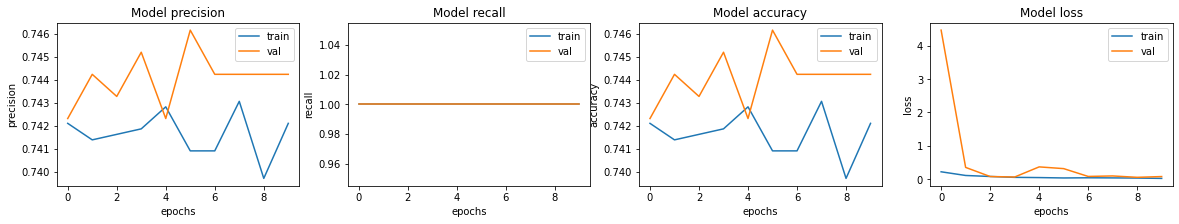

In [84]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [85]:
# 테스트 데이터로 모델 평가
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 5s 118ms/step - loss: 0.7967 - accuracy: 0.7212 - precision: 0.6922 - recall: 0.9974
Loss: 0.7967355251312256,
Accuracy: 0.7211538553237915,
Precision: 0.6921707987785339,
Recall: 0.9974358677864075


노드에서 안내된 기존 CNN 모델로 진행했을 때보다 정확도와 정밀도는 떨어졌는데, 재현율은 99% 정도를 보여준다.

**재현율**: Recall은 모델이 실제로 True인 것들 중에서 True로 예측한 비율

실제 양성인 샘플들은 모두 양성으로 예측한 것 같다.
실제 폐렴인 환자를 폐렴이 아니라고 하는 것보다, 양성으로 예측하는 게 좋은 경우라고 판단이 되기 때문에 이 분류 문제에서 재현율의 점수도 중요하다. 재현율이 나쁘지 않지만, 정확도를 높이기 위해 모델 구조를 수정해보자!

* 필터의 개수를 늘린다
* 첫 번째 Convolution layer들에 he_normal을 설정

In [86]:
# ResNet 모델 함수 정의
def resnet_block(inputs, kernel, filters, strides=1, activation='relu'):
    x = Conv2D(filters, kernel_size=(kernel,kernel), strides=strides, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation(activation)(x)
    x = Conv2D(filters, kernel_size=(kernel, kernel),padding='same')(x)
    x = BatchNormalization()(x)
    if strides != 1 or inputs.shape[3] != filters:
       inputs = Conv2D(filters, kernel_size = (1, 1), strides=strides, padding='same')(inputs)
       inputs = BatchNormalization()(inputs)
    x = Add()([inputs, x])
    x = Activation(activation)(x)
    return x

def resnet_18(input_shape, num_classes):
    inputs = Input(shape=input_shape)
    x = Conv2D(64,kernel_size=(7,7), strides=(2,2),padding='same', kernel_initializer= 'he_normal')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(3,3),strides=(2,2),padding='same')(x)
    x = resnet_block(x,3,256)
    x = resnet_block(x,3,256)
    x = resnet_block(x,3,512,strides=2)
    x = resnet_block(x,3,512)
    x = resnet_block(x,3,1024,strides=2)
    x = resnet_block(x,3,1024)
    x = resnet_block(x,3,2048,strides=2)
    x = resnet_block(x,3,2048)
    x = AveragePooling2D(pool_size=(3, 3), strides=(1, 1))(x)
    x = Flatten()(x)
    x = Dense(num_classes,activation='softmax')(x)
    model = Model(inputs=inputs,outputs=x)
    return model

In [87]:
input_shape = (180, 180, 3) #이미지의 크기
num_classes = 1 # 클래스의 숫자

model_resn1 = resnet_18(input_shape, num_classes)

model_resn1.summary()

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_21 (InputLayer)           [(None, 180, 180, 3) 0                                            
__________________________________________________________________________________________________
conv2d_260 (Conv2D)             (None, 90, 90, 64)   9472        input_21[0][0]                   
__________________________________________________________________________________________________
batch_normalization_283 (BatchN (None, 90, 90, 64)   256         conv2d_260[0][0]                 
__________________________________________________________________________________________________
activation_136 (Activation)     (None, 90, 90, 64)   0           batch_normalization_283[0][0]    
____________________________________________________________________________________________

In [88]:
with tf.device('/GPU:0'):
    
    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001) # 학습률 0.0001로 설정
    model_resn1.compile(
        optimizer=optimizer,
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [89]:
with tf.device('/GPU:0'):
    history = model_resn1.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/10
261/261 [==============================] - 158s 554ms/step - loss: 0.4405 - accuracy: 0.7419 - precision: 0.7419 - recall: 1.0000 - val_loss: 5.2348 - val_accuracy: 0.7462 - val_precision: 0.7462 - val_recall: 1.0000
Epoch 2/10
261/261 [==============================] - 145s 554ms/step - loss: 0.1570 - accuracy: 0.7416 - precision: 0.7416 - recall: 1.0000 - val_loss: 0.0838 - val_accuracy: 0.7442 - val_precision: 0.7442 - val_recall: 1.0000
Epoch 3/10
261/261 [==============================] - 145s 555ms/step - loss: 0.0994 - accuracy: 0.7416 - precision: 0.7416 - recall: 1.0000 - val_loss: 0.2557 - val_accuracy: 0.7433 - val_precision: 0.7433 - val_recall: 1.0000
Epoch 4/10
261/261 [==============================] - 144s 552ms/step - loss: 0.0826 - accuracy: 0.7416 - precision: 0.7416 - recall: 1.0000 - val_loss: 0.2117 - val_accuracy: 0.7442 - val_precision: 0.7442 - val_recall: 1.0000
Epoch 5/10
261/261 [==============================] - 145s 554ms/step - loss: 0.0665 - a

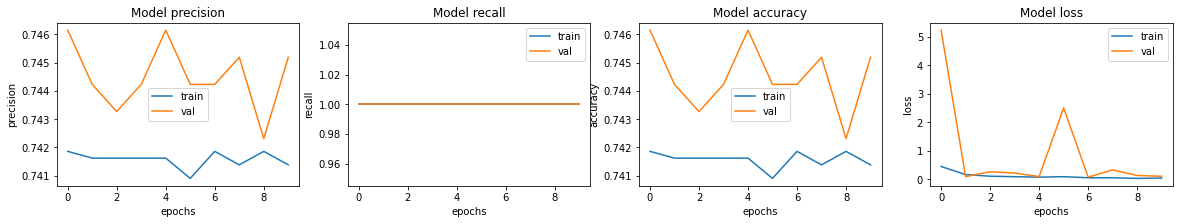

In [90]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

CNN 모델보다 더 좋지 않은 그래프를 그리고 있다. 뭐가 문제일까?
일단 결과를 출력해보자.

In [91]:
# 테스트 데이터로 모델 평가
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 5s 118ms/step - loss: 0.7967 - accuracy: 0.7212 - precision: 0.6922 - recall: 0.9974
Loss: 0.7967355847358704,
Accuracy: 0.7211538553237915,
Precision: 0.6921707987785339,
Recall: 0.9974358677864075


재현율은 여전히 높지만 정확도와 정밀도는 변함이 거의 없다. 사실 he 초기화를 모든 convolution layer에 넣은 게 아니라 첫 번째에만 넣은 것을 발견했다. 다시 수정하고 싶지만, 모델을 돌릴 시간이 없을 것 같다..

**밑에 수정 코드를 입력해두고 퀘스트 시간이 끝나고 나서도 돌려보자. 그리고 추가적으로 수정할 수 있는 하이퍼파라미터를 꼭 조절해보자.**

In [92]:
# ResNet 모델 함수 정의
def resnet_block(inputs, kernel, filters, strides=1, activation='relu'):
    x = Conv2D(filters, kernel_size=(kernel,kernel), strides=strides, padding='same', kernel_initializer= 'he_normal')(inputs)
    x = BatchNormalization()(x)
    x = Activation(activation)(x)
    x = Conv2D(filters, kernel_size=(kernel, kernel),padding='same', kernel_initializer= 'he_normal')(x)
    x = BatchNormalization()(x)
    if strides != 1 or inputs.shape[3] != filters:
       inputs = Conv2D(filters, kernel_size = (1, 1), strides=strides, padding='same')(inputs)
       inputs = BatchNormalization()(inputs)
    x = Add()([inputs, x])
    x = Activation(activation)(x)
    return x

def resnet_18(input_shape, num_classes):
    inputs = Input(shape=input_shape)
    x = Conv2D(64,kernel_size=(7,7), strides=(2,2),padding='same', kernel_initializer= 'he_normal')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(3,3),strides=(2,2),padding='same')(x)
    x = resnet_block(x,3,256)
    x = resnet_block(x,3,256)
    x = resnet_block(x,3,512,strides=2)
    x = resnet_block(x,3,512)
    x = resnet_block(x,3,1024,strides=2)
    x = resnet_block(x,3,1024)
    x = resnet_block(x,3,2048,strides=2)
    x = resnet_block(x,3,2048)
    x = AveragePooling2D(pool_size=(3, 3), strides=(1, 1))(x)
    x = Flatten()(x)
    x = Dense(num_classes,activation='softmax')(x)
    model = Model(inputs=inputs,outputs=x)
    return model

In [94]:
nput_shape = (180, 180, 3) #이미지의 크기
num_classes = 1 # 클래스의 숫자

model_resn2 = resnet_18(input_shape, num_classes)

model_resn2.summary()

Model: "model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_23 (InputLayer)           [(None, 180, 180, 3) 0                                            
__________________________________________________________________________________________________
conv2d_302 (Conv2D)             (None, 90, 90, 64)   9472        input_23[0][0]                   
__________________________________________________________________________________________________
batch_normalization_325 (BatchN (None, 90, 90, 64)   256         conv2d_302[0][0]                 
__________________________________________________________________________________________________
activation_170 (Activation)     (None, 90, 90, 64)   0           batch_normalization_325[0][0]    
____________________________________________________________________________________________

In [ ]:
with tf.device('/GPU:0'):
    
    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001) # 학습률 0.0001로 설정
    model_resn2.compile(
        optimizer=optimizer,
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [ ]:
with tf.device('/GPU:0'):
    history = model_resn2.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

In [ ]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [ ]:
# 테스트 데이터로 모델 평가
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

## 회고록

코드 이해도가 아직 떨어지는 것 같다. 평소에 학습할 때도 코드를 이해하는 게 쉽지 않았는데, 이번 코드도 대략적으로 이해하고 모델을 구현했다. 그래도 코드를 안 보는 것보다, 여러 번 보면 이해하는 데에 도움이 되는 것 같기도 하다! 언제 즈음 모든 코드를 이해할 수 있을까? ㅠㅠ
ResNet-18 모델이 어떤 모델인지는 배웠지만, 어떻게 구현해야 하는지는 노드 학습을 했음에도 불구하고, 처음엔 어떻게 구현해야 할지 몰랐다. 하지만 구글링 끝에 이해가 가는 코드를 발견해서 참고해보았다. 모델 구조를 수정하기 위해서 코드를 보다 보니, ResNet 모델 코드가 이제는 좀 이해가 되는 것 같다. 이해가 좀 가고 나서, 노드 코드를 보니 둘 다 똑같은 구조인 것을 파악할 수 있었다.
다만 아쉬운 건 코드를 이해하고 나서 좀 더 모델의 성능을 개선하기 위해, 하이퍼파라미터 등을 조절하고 싶었는데, 모델이 학습되는 시간이 무지 걸려서 더 손대볼 수 없는 게 아쉽다 ㅠㅠ

**KEEP**: 구글링을 해서라도 ResNet 모델을 구현하는 방법을 찾았던 것을 기억하며, 다음에도 모르는 것은 구글링 및 GPT 활용하기!

**Problem**: 코드 이해도가 여전히 떨어진다.. 코딩하는 법을 연습하자 ㅠ, 코드를 많이 쳐보고 손에 익히자! 차원 공부하자!

**TRY**: 하이퍼파라미터, 콜백 함수.. 등등 못 해본 게 너무 많다 ㅠ 그것들을 꼭 다시 구현해보자!